In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Import

In [ ]:
import pandas as pd

import numpy as np
from numpy.random import seed
from math import ceil


from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, max_error, mean_squared_error, mean_squared_error
from sklearn.model_selection import KFold, train_test_split
import copy

import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from itertools import cycle


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, InputLayer

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))            

In [ ]:
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
class FreezeWeights(keras.callbacks.Callback):
  def __init__(self, mask):
    super(FreezeWeights, self).__init__()
    self.mask = mask

  def on_epoch_end(self, epoch, logs=None):
    for i in range(len(self.model.layers)):
      self.model.layers[i].set_weights([np.multiply(self.model.layers[i].get_weights()[0], self.mask[i]), self.model.layers[i].get_weights()[1]])

# Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## One hot features

In [ ]:
df = pd.read_csv('drive/MyDrive/Pruning/data/yield_reg_df.csv')

In [ ]:
df.head()

,YIELD_numeric,REACTIONID,preparatory_1,preparatory_2,preparatory_3,contributor,catalyst_1,catalyst_2,catalyst_3,SMILES-ECFP4-0,...,REAGENTSMI3-ECFP4-2038,REAGENTSMI3-ECFP4-2039,REAGENTSMI3-ECFP4-2040,REAGENTSMI3-ECFP4-2041,REAGENTSMI3-ECFP4-2042,REAGENTSMI3-ECFP4-2043,REAGENTSMI3-ECFP4-2044,REAGENTSMI3-ECFP4-2045,REAGENTSMI3-ECFP4-2046,REAGENTSMI3-ECFP4-2047
0,30.400,20,4,3,1,0,5,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,80.000,20,4,3,1,0,5,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16.700,20,4,3,1,0,5,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.600,20,4,3,1,0,5,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,78.400,20,4,3,1,0,5,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59291 entries, 0 to 59290
Columns: 8201 entries, YIELD_numeric to REAGENTSMI3-ECFP4-2047
dtypes: float64(1), int64(8200)
memory usage: 3.6 GB


In [ ]:
df['REACTIONID'].value_counts()

527       19475
207       14282
34         6839
20         5266
512        3625
271570     2994
38         1912
270942     1896
2714       1535
274090     1467
Name: REACTIONID, dtype: int64

In [ ]:
df = df[df['REACTIONID'] ==  20]

In [ ]:
preparatory_1_one_hot = pd.get_dummies(df['preparatory_1'], prefix='preparatory_1')

In [ ]:
preparatory_2_one_hot = pd.get_dummies(df['preparatory_2'], prefix='preparatory_2')

In [ ]:
preparatory_3_one_hot = pd.get_dummies(df['preparatory_3'], prefix='preparatory_3')

In [ ]:
contributor_one_hot = pd.get_dummies(df['contributor'], prefix='contributor')

In [ ]:
catalyst_1_one_hot = pd.get_dummies(df['catalyst_1'], prefix='catalyst_1')

In [ ]:
catalyst_2_one_hot = pd.get_dummies(df['catalyst_2'], prefix='catalyst_2')

In [ ]:
catalyst_3_one_hot = pd.get_dummies(df['catalyst_3'], prefix='catalyst_3')

In [ ]:
df_one_hot = df.join([preparatory_1_one_hot, preparatory_2_one_hot, preparatory_3_one_hot, contributor_one_hot, catalyst_1_one_hot, catalyst_2_one_hot, catalyst_3_one_hot])

In [ ]:
df_one_hot.drop(['REACTIONID', 'preparatory_1', 'preparatory_2', 'preparatory_3', 'contributor', 'catalyst_1', 'catalyst_2', 'catalyst_3'], axis=1,inplace=True)

In [ ]:
df_one_hot.to_csv('drive/MyDrive/Pruning/data/yield_reg_one_hot_REACTIONID_20_df.csv', index=False)

In [ ]:
df_one_hot

,YIELD_numeric,SMILES-ECFP4-0,SMILES-ECFP4-1,SMILES-ECFP4-2,SMILES-ECFP4-3,SMILES-ECFP4-4,SMILES-ECFP4-5,SMILES-ECFP4-6,SMILES-ECFP4-7,SMILES-ECFP4-8,...,preparatory_1_0,preparatory_1_1,preparatory_1_4,preparatory_2_0,preparatory_2_3,preparatory_3_1,contributor_0,catalyst_1_5,catalyst_2_2,catalyst_3_0
0,30.400,0,1,0,0,0,1,0,0,0,...,0,0,1,0,1,1,1,1,1,1
1,80.000,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,1,1,1,1,1
2,16.700,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,1,1,1
3,2.600,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,1,1,1,1,1
4,78.400,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5261,15.100,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,1,1,1,1,1
5262,25.900,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,1,1,1,1
5263,48.600,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,1,1,1,1
5264,53.500,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,1,1,1,1


In [ ]:
df_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5266 entries, 0 to 5265
Columns: 8203 entries, YIELD_numeric to catalyst_3_0
dtypes: float64(1), int64(8192), uint8(10)
memory usage: 329.4 MB


## Data load

In [ ]:
df = pd.read_csv('drive/MyDrive/Pruning/data/yield_reg_one_hot_REACTIONID_20_df.csv')

In [ ]:
df.head()

,YIELD_numeric,SMILES-ECFP4-0,SMILES-ECFP4-1,SMILES-ECFP4-2,SMILES-ECFP4-3,SMILES-ECFP4-4,SMILES-ECFP4-5,SMILES-ECFP4-6,SMILES-ECFP4-7,SMILES-ECFP4-8,...,preparatory_1_0,preparatory_1_1,preparatory_1_4,preparatory_2_0,preparatory_2_3,preparatory_3_1,contributor_0,catalyst_1_5,catalyst_2_2,catalyst_3_0
0,30.400,0,1,0,0,0,1,0,0,0,...,0,0,1,0,1,1,1,1,1,1
1,80.000,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,1,1,1,1,1
2,16.700,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,1,1,1
3,2.600,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,1,1,1,1,1
4,78.400,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,1,1,1,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5266 entries, 0 to 5265
Columns: 8203 entries, YIELD_numeric to catalyst_3_0
dtypes: float64(1), int64(8202)
memory usage: 329.6 MB


In [ ]:
train, test = train_test_split(df, test_size=0.2, shuffle=True)

# Train model

In [ ]:
SEED = 42
def set_seed():
  seed(SEED)
  tf.random.set_seed(SEED)

In [ ]:
class Mask:

  def __init__(self, model_struct=None, mask_array=None):
    if mask_array is not None:
      self.mask_array = mask_array
    else:
      self.mask_array = self._mask_init(model_struct)
    
  def _mask_init(self, model_struct):
    mask = []
    for layer in model_struct.layers:
      mask.append(np.ones_like(layer.get_weights()[0]))
    return np.asarray(mask, dtype=object)

  def get_callback(self):
    return FreezeWeights(copy.deepcopy(self.mask_array))

  def get_undropped_neuron_count(self):
    unpack = []

    for i in self.mask_array:
      unpack.extend(i.ravel())
    return np.sum(unpack)
  
  def get_neuron_count(self):

    unpack = []

    for i in self.mask_array:
      unpack.extend(i.ravel())
    
    return len(unpack)


  def drop_weights(self, drop_indexes):
    mask = copy.deepcopy(self.mask_array)
    for layer, indexes in drop_indexes.items():
      for index in indexes:
        if index.size == 1:
          mask[layer][index][0] = 0
        else:
          mask[layer][index[0]][index[1]] = 0
    return mask
  

In [ ]:
@dataclass
class DataPeace:
  x: pd.DataFrame
  y: pd.Series

In [ ]:
@dataclass
class DataFold:
  train: DataPeace
  valid: DataPeace

In [ ]:
class DataContainer:

  def __init__(self, train_data, test_data, features, target, cv):
    self.train_data = train_data
    self.features = features
    self.target = target

    self.data_folds = self.folds_split(cv)
    self.data_test = DataPeace(
        test_data[features],
        test_data[target]
    )

  def folds_split(self, cv):
    folders = []
    
    kfold = KFold(n_splits=cv, shuffle=True)
    for train, test in kfold.split(self.train_data):
      folders.append(
          DataFold(
              DataPeace(
                  self.train_data.iloc[train][self.features],
                  self.train_data.iloc[train][self.target]),
              DataPeace(
                  self.train_data.iloc[test][self.features],
                  self.train_data.iloc[test][self.target])
              )
          )

    return folders
    

In [ ]:
class ModelsGenerator:

  def __init__(self, model_struct, compile_params, weights=None, biases=None):
    self.model_struct = model_struct
    self.compile_params = compile_params

    if weights is None or biases is None:
      weights = []
      biases = []
      for layer in model_struct.layers:
        weights.append(layer.get_weights()[0])
        biases.append(layer.get_weights()[1])
    self.weights = weights
    self.biases = biases

  def create_model(self, weights=None, biases=None):
    if weights is None or biases is None:
      weights = self.weights
      biases = self.biases

    weights = copy.deepcopy(weights)
    biases = copy.deepcopy(biases)

    set_seed()

    model = keras.models.clone_model(model=self.model_struct)
    model.compile(**self.compile_params)    

    for layer, layer_weight, layer_bias in zip(model.layers, weights, biases):
      layer.set_weights([layer_weight, layer_bias])

    return model

  def create_models(self, models_n,  weights=None, biases=None):
    return [self.create_model(weights, biases) for _ in range(models_n)]

In [ ]:
class ModelsController:
  
  def __init__(self):
    self.target_models = []
    self.folds_models = []

  @staticmethod
  def get_model_weights(model):
    weights_arr = []
    biases_arr = []

    for layer in model.layers:
      weights_arr.append(layer.get_weights()[0])
      biases_arr.append(layer.get_weights()[1])

    return copy.deepcopy(weights_arr), copy.deepcopy(biases_arr)

  def get_models(self):
    return {'target_models': self.target_models, 'folds_models': self.folds_models}

  def models_generate(self, generator, models_n, folders_n):
    
    self.target_models = generator.create_models(models_n=folders_n)
    self.folds_models = [generator.create_models(models_n=models_n) for _ in range(folders_n)]


  def target_models_fit(self, train_data, epochs, callbacks):

    for model, fold in zip(self.target_models, train_data):
      set_seed()
      model.fit(
          x=fold.train.x,
          y=fold.train.y,
          validation_data=(fold.valid.x, fold.valid.y),
          epochs=epochs,
          callbacks=callbacks,
          verbose=False,
          batch_size=512)

  def folds_models_fit(self, train_data, epochs, callbacks, optimizer):

    for models_fold, fold in zip(self.folds_models, train_data):
      
      for model in models_fold:
        y_train, y_valid = optimizer.shuffle_noise(fold.train.y, fold.valid.y)
        set_seed()
        model.fit(
            x=fold.train.x,
            y=y_train,
            validation_data=(fold.valid.x, y_valid),
            epochs=epochs,
            callbacks=callbacks,
            verbose=False,
            batch_size=512)
  

  def evaluate(self, data_test, metrics):
    scores = []

    for model in self.target_models:
      model_score = []

      y_pred = np.array(model.predict(data_test.x)).reshape(-1)

      for metric_name, metric in metrics.items():

        metric_score = metric(data_test.y, y_pred)

        model_score.append(metric_score)

        print(f'{metric_name}: {metric_score}', end=' ')
      
      scores.append(model_score)

      print()
    
    mean_score = np.mean(scores, axis=0)

    mean_score_dict = dict(zip(metrics.keys(), mean_score))

    return mean_score_dict

In [ ]:
class RegressionWeightsOptimizer:

  def __init__(self, dr, drl, models_n):
    self.dr = dr
    self.drl = drl
    self.noise = cycle(np.linspace(0.9, 1.1, models_n))

  def shuffle_noise(self, y_train, y_valid):
    noise = next(self.noise)
    return np.multiply(y_train, noise), np.multiply(y_valid,noise)

  @staticmethod
  def get_dispersion_weights(target_models, folds_models):

    weight_dispersion = []

    for target_model, fold_models in zip(target_models, folds_models):

      target_weights, _ = ModelsController.get_model_weights(target_model)

      fold_weights = []

      for model in fold_models:
        weights, _ = ModelsController.get_model_weights(model)
        fold_weights.append(weights)

      weight_dispersion.append(np.mean(np.abs(np.divide(np.subtract(fold_weights, target_weights), fold_weights)), axis=0))
    
    mean_dispersion = np.mean(np.array(weight_dispersion), axis=0)

    return mean_dispersion

  def dr_low(self):
    self.dr = self.dr * self.drl


  def drop_weights_indexes(self, weights_dispersion, mask):
    weights_unpack = []

    for layer in weights_dispersion:
        layer = np.nan_to_num(layer)
        weights_unpack.extend(layer.ravel())

    weights_unpack = np.array(weights_unpack)

    drop_threshold_idx = ceil(mask.get_neuron_count() * self.dr)

    threshold_drop = np.sort(weights_unpack)[-drop_threshold_idx]

    drop_indexes = {}

    dropped_count = 0

    for i, layer in enumerate(weights_dispersion):

        indexes = np.argwhere(layer >= threshold_drop)

        dropped_count += len(indexes)

        if indexes.size != 0:
            drop_indexes[i] = indexes

    print(f'\nWeights was {mask.get_undropped_neuron_count()} dropped: {dropped_count}')

    return drop_indexes


In [ ]:
class ModelsCheckpoint:

  def __init__(self):
    self.saved_masks = [None, None]
    self.saved_target_weights = [None, None]
    self.saved_folders_weights = [None, None]
    self.scores = [None, None]

    self.best_mask = None
    self.best_target_weights = None
    self.best_score = None
  
  def _save(self, arr, elem):
    arr.pop(0)
    arr.append(copy.deepcopy(elem))

  def create_checkpoint(self, mask, target_models, folds_models, score):    
    target_models_weights = [model.get_weights() for model in target_models]

    folders_models_weights = [[model.get_weights() for model in fold] for fold in folds_models]

    self._save(self.saved_masks, mask.mask_array)
    self._save(self.saved_target_weights, target_models_weights)
    self._save(self.saved_folders_weights, folders_models_weights)

    self._save(self.scores, score)

  def save_best_params(self, score, mask, target_models):
    self.best_score = score
    self.best_mask = copy.deepcopy(mask)
    self.best_target_weights = copy.deepcopy([model.get_weights() for model in target_models])

  def check_model_better(self, score, mask, target_models):
    if self.scores[-1] is None:
      self.save_best_params(score, mask, target_models)
      return True
    else:
      if score['loss'] < self.scores[-1]['loss']:
        if score['loss'] < self.best_score['loss']:
          self.save_best_params(score, mask, target_models)
        return True
      else:
        return False

  def models_set_weights(self, models, weights):
    for model, weight in zip(models, weights):
      model.set_weights(weight)


  def roll_back(self, mask, target_models, folds_models):

    for i in range(2):
      
      if self.saved_masks[i] is not None:

        mask.mask_array = copy.deepcopy(self.saved_masks[i])

        self.models_set_weights(target_models, self.saved_target_weights[i])

        for fold_models, weights in zip(folds_models, self.saved_folders_weights[i]):
          
          self.models_set_weights(fold_models, weights)

      self.saved_masks = [None, self.saved_masks[i]]
      self.saved_target_weights = [None, self.saved_target_weights[i]]
      self.saved_folders_weights = [None, self.saved_folders_weights[i]]
      self.scores = [None, self.scores[i]]
      break

In [ ]:
class Pruning:

  def __init__(self, weights_optimizer, data):

    self.weights_optimizer = weights_optimizer
    self.data_container = data

    self.mask = None
    self.models_controller = None
    self.checkpointer = ModelsCheckpoint()

  def model_compile(self, model_struct, compile_params, models_n, folders):
    model_struct.build()

    controller = ModelsController()
    generator = ModelsGenerator(model_struct, compile_params)
    controller.models_generate(generator, models_n, folders)

    self.models_controller = controller
    self.mask = Mask(model_struct=model_struct)  

  def _get_callbacks(self):
    early_stop_callback = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=200,
        mode='min',
        restore_best_weights=True)
    
    return [early_stop_callback, self.mask.get_callback()]


  def fit(self, iter, epochs, metrics):

    history = []

    print(f'Weights count: {self.mask.get_undropped_neuron_count()}')

    for i in range(iter):
      
      callbacks = self._get_callbacks()

      self.models_controller.target_models_fit(self.data_container.data_folds, epochs, callbacks)
      score = self.models_controller.evaluate(self.data_container.data_test, metrics)

      if not self.checkpointer.check_model_better(score, self.mask.mask_array, self.models_controller.target_models):
        print('Rollback')

        self.checkpointer.roll_back(self.mask, **self.models_controller.get_models())
        self.weights_optimizer.dr_low()

        print('Create new mask')
        weights_dispersion = self.weights_optimizer.get_dispersion_weights(**self.models_controller.get_models())
        drop_indexes = self.weights_optimizer.drop_weights_indexes(weights_dispersion, self.mask)

        self.mask = Mask(mask_array=self.mask.drop_weights(drop_indexes))

        continue


      self.models_controller.folds_models_fit(self.data_container.data_folds, epochs, callbacks, self.weights_optimizer)

      weights_dispersion = self.weights_optimizer.get_dispersion_weights(**self.models_controller.get_models())
      drop_indexes = self.weights_optimizer.drop_weights_indexes(weights_dispersion, self.mask)

      self.checkpointer.create_checkpoint(mask = self.mask, score= score,**self.models_controller.get_models())

      history.append(score)

      self.mask = Mask(mask_array=self.mask.drop_weights(drop_indexes))
      
    final_score = self.models_controller.evaluate(self.data_container.data_test, metrics)

    print(f'Weights on start {self.mask.get_neuron_count()}, weights after fit {self.mask.get_undropped_neuron_count()}, weights dropped {self.mask.get_neuron_count() - self.mask.get_undropped_neuron_count()}')

    return history


In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(8202,)))
model.add(Dense(units=2048, activation='relu'))
model.add(Dense(1))

compile_params = {
    'loss': RMSE,
    'optimizer': 'adam'}

metrics = {
    'loss': RMSE,
    'R2':r2_score,
    'MSE': mean_squared_error,
    'MAE': mean_absolute_error,
    'max_error': max_error,
    'explained_variance':explained_variance_score
}

data = DataContainer(train, test, train.columns.drop('YIELD_numeric'), 'YIELD_numeric', 3)

weights_optimizer = RegressionWeightsOptimizer(dr=0.1, drl=0.5, models_n=2)

prun = Pruning(weights_optimizer, data)

prun.model_compile(
    model_struct=model, 
    compile_params=compile_params, 
    models_n=2, 
    folders=3)


In [ ]:
history = prun.fit(20, 5000, metrics)

Weights count: 16799744.0
loss: 22.257861924089095 R2: 0.2664949416659744 MSE: 495.41241743181513 MAE: 17.212072251643807 max_error: 71.61095275878907 explained_variance: 0.26736600701896707 
loss: 21.524536371406978 R2: 0.3140320314729751 MSE: 463.30566600402193 MAE: 16.79346405896561 max_error: 63.92469596862793 explained_variance: 0.31576754463706613 
loss: 21.732890268348985 R2: 0.3006876474099921 MSE: 472.3185194160982 MAE: 16.76995748328982 max_error: 77.39287776947022 explained_variance: 0.30099803187266283 

Weights was 16799744.0 dropped: 1679975
loss: 21.93890475416871 R2: 0.2873667026668103 MSE: 481.31554181248646 MAE: 17.12767732310793 max_error: 69.17660751342774 explained_variance: 0.2873870428677331 
loss: 21.38885852226786 R2: 0.3226526424785253 MSE: 457.4832688855905 MAE: 16.76670504738303 max_error: 64.69351806640626 explained_variance: 0.32278084163952314 
loss: 21.48478787782892 R2: 0.31656319100474273 MSE: 461.5961101553047 MAE: 16.63833759333196 max_error: 77.6329

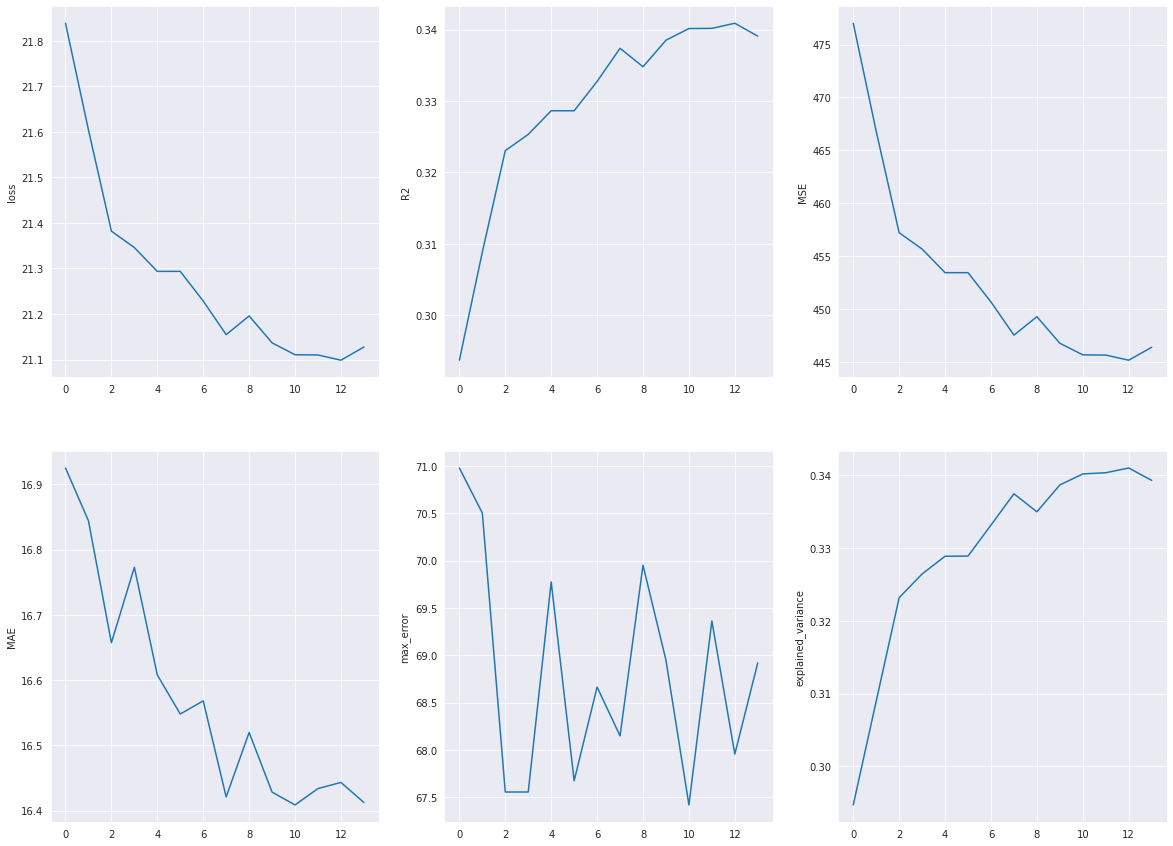

In [ ]:
logs_df = pd.DataFrame(history, columns=metrics.keys())
fig, axs = plt.subplots(
    nrows=2, ncols=3,
    figsize=(20, 15)
)


counter = 0

column = logs_df.columns


for i in range(2):
  for j in range(3):
    sns.lineplot(x=logs_df.index, y = logs_df[column[counter]], ax=axs[i][j])
    counter += 1

plt.show()

Зміна метрик


In [ ]:
logs_df.iloc[-1] - logs_df.iloc[0]

loss                  -0.711
R2                     0.045
MSE                  -30.619
MAE                   -0.513
max_error             -2.056
explained_variance     0.045
dtype: float64

Зміна ваг

In [ ]:
start_weights_count = prun.mask.get_neuron_count()
finish_weights_count = prun.mask.get_undropped_neuron_count()
weights_dropped = start_weights_count - finish_weights_count
print(f'Start weights count: {start_weights_count}\nFinish weights count: {finish_weights_count}\nWeights dropped: {weights_dropped}')

Start weights count: 16799744
Finish weights count: 11891065.0
Weights dropped: 4908679.0
